<a href="https://colab.research.google.com/github/kopeomojola/Tokyo2020/blob/main/Olympic_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with an RNN

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/drive/1EaAYMOMrPz9bR6URojmgO1Ta9rwavCo1#scrollTo=dLvpRCsE-GnC">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/kopeomojola/Tokyo2020/blob/main/Olympic_Sentiment_Analysis.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Sentiment Analysis with an Recurrent Neural Network

We will use a RNN for sentiment analysis because we care for the sequence in the data.

### Imports
Importing numpy for 

In [3]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

### Loading in Dataset

In [4]:
url = 'https://raw.githubusercontent.com/kopeomojola/Tokyo2020/main/datas.csv'
data = pd.read_csv(url)
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(9868, 10)


,Unnamed: 0,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,3702,@Anna35876145 True Olympic Champions!,true olympic champions,0.35,0.65,positive,0.000,0.139,0.861,0.7351
1,2818,"@CSLewisDaily Sorry, i am not a Archer to aim ...",sorry i am not a archer to aim at pls ca...,-0.50,1.00,neutral,0.096,0.809,0.096,0.0000
2,844,@Girl_Lafleur He’s our rat! 🇨🇦🇨🇦🇨🇦 would’ve wo...,lafleur he s our rat would ve won ol...,0.00,0.00,positive,0.000,0.730,0.270,0.5719
3,1844,getting ready for the hood olympics like http...,getting ready for the hood olympics like,0.20,0.50,positive,0.000,0.500,0.500,0.6124
4,4190,Figure Skating Body Details Proposal to Hike A...,figure skating body details proposal to hike a...,0.00,0.00,neutral,0.000,1.000,0.000,0.0000


Removing all columns except the sentiment and text column.

In [5]:
data = data[['sentiment', 'text']]
data.head()

,sentiment,text
0,positive,true olympic champions
1,neutral,sorry i am not a archer to aim at pls ca...
2,positive,lafleur he s our rat would ve won ol...
3,positive,getting ready for the hood olympics like
4,neutral,figure skating body details proposal to hike a...


### Data exploration

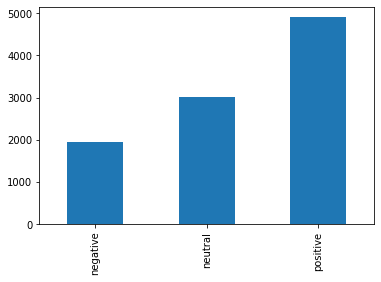

In [6]:
data['sentiment'].value_counts().sort_index().plot.bar()

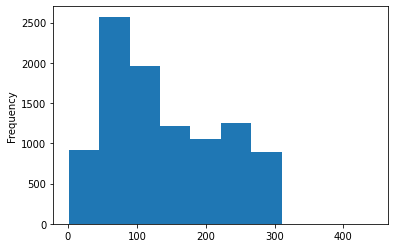

In [7]:
data['text'].str.len().plot.hist()

### Preprocessing

In [8]:
data['text'] = data['text'].str.replace('@', '')
data.head()

,sentiment,text
0,positive,true olympic champions
1,neutral,sorry i am not a archer to aim at pls ca...
2,positive,lafleur he s our rat would ve won ol...
3,positive,getting ready for the hood olympics like
4,neutral,figure skating body details proposal to hike a...


In [9]:
data['text'].apply(lambda x: x.lower()) #transform text to lowercase
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['text'].head()

0                              true olympic champions 
1      sorry  i am not a archer to aim at    pls ca...
2      lafleur he s our rat         would ve won ol...
3          getting ready for the hood olympics like   
4    figure skating body details proposal to hike a...
Name: text, dtype: object

In [10]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         488,    2,  441],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  698,
           

### Creating model

In [11]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 256)           1280000   
                                                                 
 dropout (Dropout)           (None, 80, 256)           0         
                                                                 
 lstm (LSTM)                 (None, 80, 256)           525312    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [13]:
y = pd.get_dummies(data['sentiment']).values
[print(data['sentiment'][i], y[i]) for i in range(0,5)]

positive [0 0 1]
neutral [0 1 0]
positive [0 0 1]
positive [0 0 1]
neutral [0 1 0]


[None, None, None, None, None]

### Training model

In [14]:
pip install imblearn

In [15]:
from imblearn.over_sampling import RandomOverSampler

In [16]:
over_sampler = RandomOverSampler(sampling_strategy="minority")

In [17]:
X_oversampled, y_oversampled = over_sampler.fit_resample(X, y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=42)

In [19]:
batch_size = 64
epochs = 70

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test,y_test), batch_size=batch_size, verbose=1)

Epoch 1/70
161/161 [==============================] - 216s 1s/step - loss: 0.7919 - accuracy: 0.6174 - val_loss: 0.5560 - val_accuracy: 0.7748
Epoch 2/70
161/161 [==============================] - 184s 1s/step - loss: 0.3775 - accuracy: 0.8637 - val_loss: 0.4080 - val_accuracy: 0.8496
Epoch 3/70
161/161 [==============================] - 184s 1s/step - loss: 0.2209 - accuracy: 0.9283 - val_loss: 0.4035 - val_accuracy: 0.8652
Epoch 4/70
161/161 [==============================] - 183s 1s/step - loss: 0.1515 - accuracy: 0.9545 - val_loss: 0.4075 - val_accuracy: 0.8746
Epoch 5/70
161/161 [==============================] - 185s 1s/step - loss: 0.1193 - accuracy: 0.9621 - val_loss: 0.4107 - val_accuracy: 0.8820
Epoch 6/70
161/161 [==============================] - 183s 1s/step - loss: 0.0944 - accuracy: 0.9715 - val_loss: 0.4460 - val_accuracy: 0.8788
Epoch 7/70
161/161 [==============================] - 183s 1s/step - loss: 0.0713 - accuracy: 0.9800 - val_loss: 0.4954 - val_accuracy: 0.8866

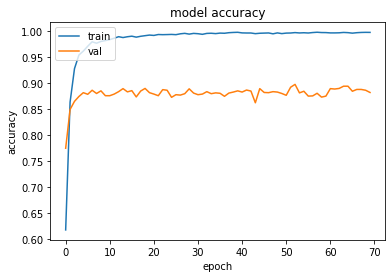

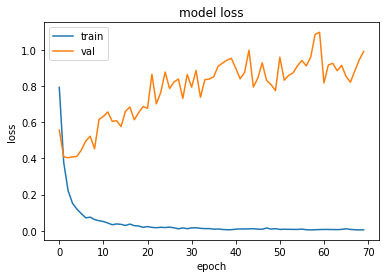

In [20]:
#plot accuracy and recall
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()




model.save('sentiment_analysis.h5')

### Testing model

In [21]:
predictions = model.predict(X_test)

[print(data['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

  true olympic champions  [2.4940773e-06 9.9999201e-01 5.5242681e-06] [0 1 0]
  sorry  i am not a archer to aim at    pls call an olympics gold medalist [9.9999642e-01 3.0026122e-06 5.4671096e-07] [1 0 0]
  lafleur he s our rat         would ve won olympic gold in beijing [9.9997556e-01 2.3841594e-05 6.0439720e-07] [1 0 0]
getting ready for the hood olympics like    [9.9999857e-01 5.4696716e-07 8.5576079e-07] [1 0 0]
figure skating body details proposal to hike age limit to 17 for 2026 winter olympics    [9.9998713e-01 4.4462154e-06 8.4083485e-06] [1 0 0]


[None, None, None, None, None]

In [22]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 985
Neutral predictions: 522
Negative predictions: 1060
Real positive: 1037
Real neutral: 602
Real negative: 928


In [23]:
total_result = int(real_pos) + int(real_neu) + int(real_neg)
print(total_result)

per_real_pos = (real_pos/total_result)*100
per_real_neu = (real_neu/total_result)*100
per_real_neg = (real_neg/total_result)*100
print(per_real_pos)
print(per_real_neu)
print(per_real_neg)
total_percentage = per_real_neg + per_real_pos + per_real_neu
print(total_percentage)

2567
40.397350993377486
23.451499805220102
36.15114920140242
100.0


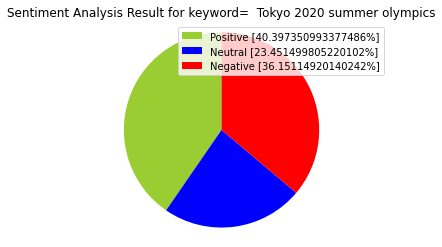

In [24]:
keyword = "Tokyo 2020 summer olympics"
labels = ['Positive ['+str(per_real_pos)+'%]' , 'Neutral ['+str(per_real_neu)+'%]','Negative ['+str(per_real_neg)+'%]']
sizes = [real_pos, real_neu, real_neg]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword=  "+keyword+"" )
plt.axis('equal')
plt.show()

In [25]:
y_pred=np.argmax(predictions, axis=1)
y_true=np.argmax(y_test, axis=1)

[[888  14  26]
 [ 66 477  59]
 [106  31 900]]


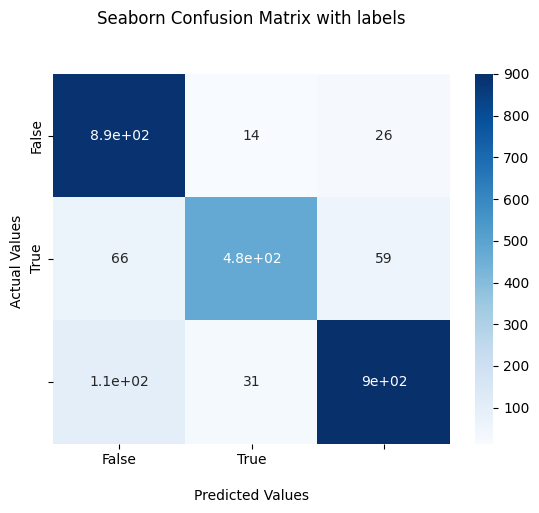

In [26]:
cf_matrix = confusion_matrix(y_true, y_pred)

print(cf_matrix)

mt = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

mt.set_title('Seaborn Confusion Matrix with labels\n\n');
mt.set_xlabel('\nPredicted Values')
mt.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
mt.xaxis.set_ticklabels(['False','True'])
mt.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()